In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import random


### Load Data and Prepare 

In [20]:
def load_mnist_pairs():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_data = np.concatenate([x_train, x_test])
    y_data = np.concatenate([y_train, y_test])
    x_data = x_data.astype("float32") / 255.
    x_data = np.expand_dims(x_data, axis=-1)

    digit_indices = [np.where(y_data == i)[0] for i in range(10)]
    
    # Create pairs
    pairs, labels = [], []
    for _ in range(30000):
        # Positive pair
        digit = random.randint(0, 9)
        idx1, idx2 = np.random.choice(digit_indices[digit], 2, replace=False)
        pairs.append([x_data[idx1], x_data[idx2]])
        labels.append(1)
        
        # Negative pair
        d1, d2 = random.sample(range(10), 2)
        idx1 = np.random.choice(digit_indices[d1])
        idx2 = np.random.choice(digit_indices[d2])
        pairs.append([x_data[idx1], x_data[idx2]])
        labels.append(0)

    return np.array(pairs), np.array(labels).astype("float32")


### Define the Model

In [21]:
def create_base_network(input_shape):
    input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu')(input)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
    return models.Model(input, x)


### Binary Cross-Entropy Loss

In [22]:
def build_bce_model(input_shape):
    base_network = create_base_network(input_shape)
    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)
    
    emb_a = base_network(input_a)
    emb_b = base_network(input_b)
    
    x = layers.concatenate([emb_a, emb_b])
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model([input_a, input_b], x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


### Contrastive Loss

In [23]:
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    return tf.reduce_mean(y_true * tf.square(y_pred) + (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0)))

def build_contrastive_model(input_shape):
    base_network = create_base_network(input_shape)
    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)

    emb_a = base_network(input_a)
    emb_b = base_network(input_b)

    l2_distance = layers.Lambda(lambda tensors: tf.sqrt(tf.reduce_sum(tf.square(tensors[0] - tensors[1]), axis=1, keepdims=True)))(
        [emb_a, emb_b])
    
    model = models.Model([input_a, input_b], l2_distance)
    model.compile(loss=contrastive_loss, optimizer='adam')
    return model


### Triplet Loss

In [24]:
def create_triplets(x_data, y_data, n_samples=30000):
    digit_indices = [np.where(y_data == i)[0] for i in range(10)]
    triplets = []
    for _ in range(n_samples):
        a_digit = random.randint(0, 9)
        a, p = np.random.choice(digit_indices[a_digit], 2, replace=False)
        n_digit = random.choice([i for i in range(10) if i != a_digit])
        n = np.random.choice(digit_indices[n_digit])
        triplets.append([x_data[a], x_data[p], x_data[n]])
    return np.array(triplets)

# Load data
(x_train_m, y_train_m), (_, _) = mnist.load_data()
x_train_m = x_train_m.astype("float32") / 255.
x_train_m = np.expand_dims(x_train_m, axis=-1)

# Generate triplets
triplets = create_triplets(x_train_m, y_train_m, n_samples=30000)

# Split manually into train/val (80/20)
split_idx = int(0.8 * len(triplets))
anchor_train = triplets[:split_idx, 0]
pos_train = triplets[:split_idx, 1]
neg_train = triplets[:split_idx, 2]

anchor_val = triplets[split_idx:, 0]
pos_val = triplets[split_idx:, 1]
neg_val = triplets[split_idx:, 2]

y_dummy_train = np.zeros(len(anchor_train))
y_dummy_val = np.zeros(len(anchor_val))

# Build and train the model
triplet_model = build_triplet_model((28, 28, 1))
history_triplet = triplet_model.fit(
    [anchor_train, pos_train, neg_train],
    y_dummy_train,
    validation_data=([anchor_val, pos_val, neg_val], y_dummy_val),
    epochs=10,
    batch_size=128
)


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0313 - val_loss: 0.0071
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0012 - val_loss: 0.0037
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 9.2904e-04 - val_loss: 0.0036
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 5.7824e-04 - val_loss: 0.0025
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 4.9098e-04 - val_loss: 0.0029
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 3.1539e-04 - val_loss: 0.0038
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 4.4851e-04 - val_loss: 0.0028
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 4.3768e-04 - val_loss: 0.0026


### Train and Visualize

In [25]:
pairs, labels = load_mnist_pairs()
input_shape = pairs[0][0].shape

# Split data
x_train, x_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2)

# BCE
bce_model = build_bce_model(input_shape)
history_bce = bce_model.fit([x_train[:,0], x_train[:,1]], y_train, validation_split=0.2, epochs=10)

# Contrastive
contrast_model = build_contrastive_model(input_shape)
history_contrast = contrast_model.fit([x_train[:,0], x_train[:,1]], y_train, validation_split=0.2, epochs=10)


Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6864 - loss: 0.5369 - val_accuracy: 0.9469 - val_loss: 0.1542
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9657 - loss: 0.1078 - val_accuracy: 0.9815 - val_loss: 0.0611
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9895 - loss: 0.0353 - val_accuracy: 0.9853 - val_loss: 0.0437
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9951 - loss: 0.0175 - val_accuracy: 0.9889 - val_loss: 0.0337
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9964 - loss: 0.0127 - val_accuracy: 0.9891 - val_loss: 0.0362
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9974 - loss: 0.0086 - val_accuracy: 0.9890 - val_loss: 0.0346
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9984 - loss: 0.0058 - val_accuracy: 0.9916 - val_loss: 0.0272
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9974 - loss: 

### Visualization

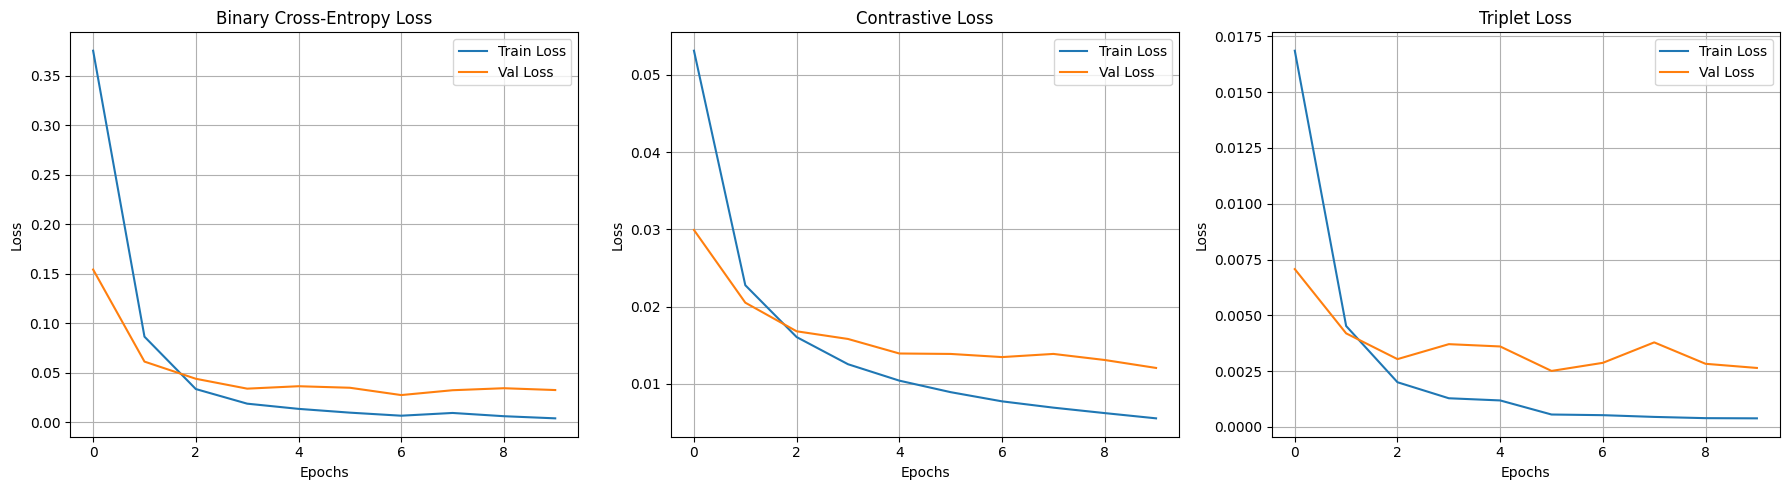

In [27]:
import matplotlib.pyplot as plt

def plot_all_losses(history_bce, history_contrast, history_triplet):
    plt.figure(figsize=(18,5))

    # ===== BCE Plot =====
    plt.subplot(1, 3, 1)
    plt.plot(history_bce.history['loss'], label='Train Loss')
    plt.plot(history_bce.history['val_loss'], label='Val Loss')
    plt.title("Binary Cross-Entropy Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # ===== Contrastive Plot =====
    plt.subplot(1, 3, 2)
    plt.plot(history_contrast.history['loss'], label='Train Loss')
    plt.plot(history_contrast.history['val_loss'], label='Val Loss')
    plt.title("Contrastive Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # ===== Triplet Plot =====
    plt.subplot(1, 3, 3)
    plt.plot(history_triplet.history['loss'], label='Train Loss')
    plt.plot(history_triplet.history['val_loss'], label='Val Loss')
    plt.title("Triplet Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to display the plots
plot_all_losses(history_bce, history_contrast, history_triplet)
